# Compute Intensity Maps
Generate forward-modeled intensities using full emission model.

In [1]:
import os
import sys
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
import dask
import distributed
import sunpy.map
from astropy.visualization import SqrtStretch,ImageNormalize,AsinhStretch,LogStretch

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.visualize import plot_aia_channels,make_aia_animation
from synthesizAR.atomic import EmissionModel

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#cluster = distributed.LocalCluster(threads_per_worker=1,n_workers=32,memory_limit='8GB')
client = distributed.Client()#cluster)
client

Client Scheduler: tcp://127.0.0.1:35898 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/field_checkpoint/')

In [4]:
em_model = EmissionModel.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/emission_model.json')

In [3]:
aia = InstrumentSDOAIA([5e3,2.5e4] * u.s, field.magnetogram.observer_coordinate)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [4]:
observer = synthesizAR.Observer(field,[aia],parallel=True)

In [5]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/', ds=0.5 * u.Mm,)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [8]:
tasks_flatten = observer.flatten_detector_counts(emission_model=em_model,interpolate_hydro_quantities=False)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/worker.py:820: UserWarning: Large object of size 1.10 MB detected in task graph: 
  ({'wavelength': <Quantity 94. Angstrom>, 'telescop ... pix s)>, None])
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [8]:
tasks_bin = observer.bin_detector_counts('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:52398 remote=tcp://127.0.0.1:35898>


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


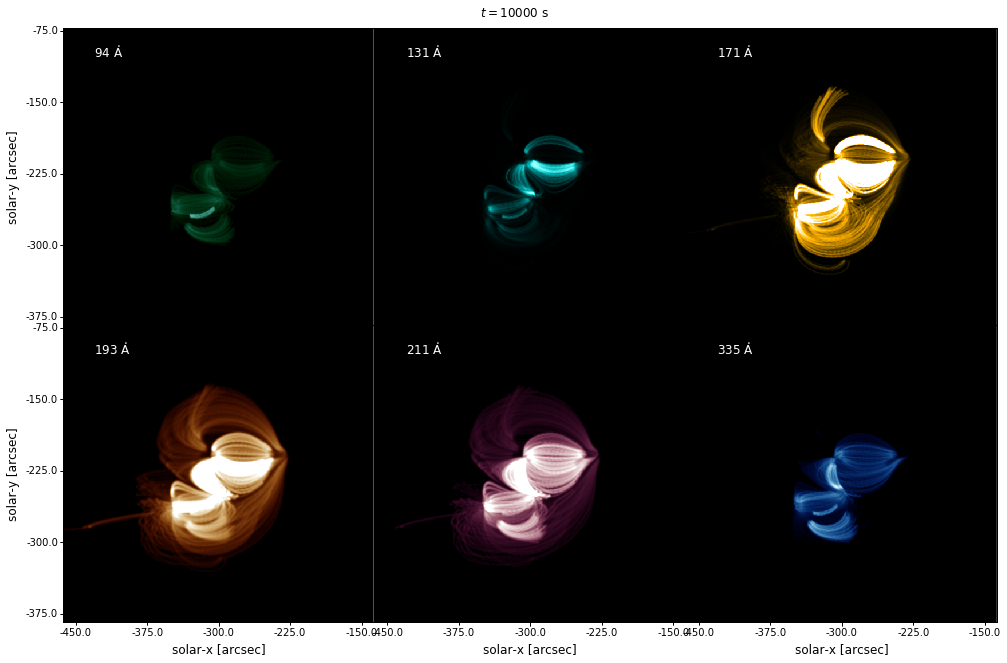

In [20]:
plot_aia_channels(aia, 10e3*u.s, '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/',
                  norm=ImageNormalize(vmin=0,vmax=1e2,stretch=AsinhStretch()),#ImageNormalize(vmin=0,vmax=1e-2,stretch=SqrtStretch())
                  figsize=(16.75,10),fontsize=12
                 )

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


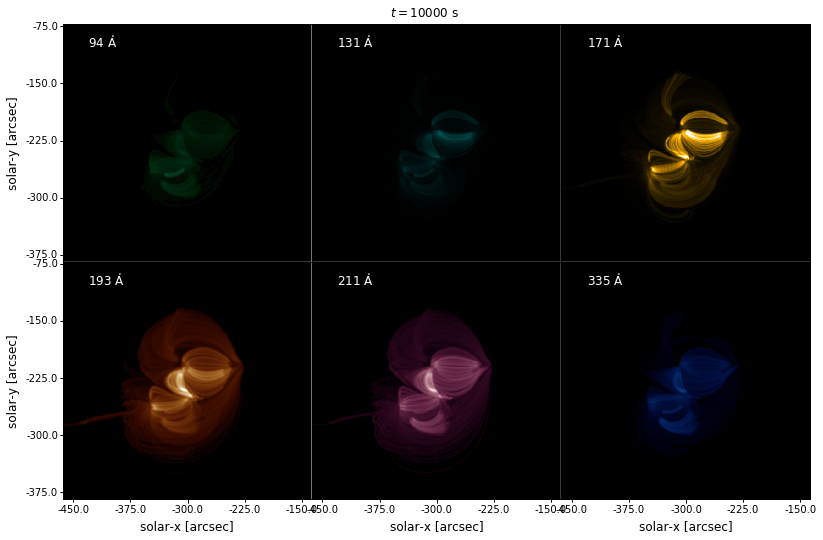

In [38]:
anim = make_aia_animation(aia, aia.observing_time[0], aia.observing_time[0]+1e4*u.s, '/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/',
                          norm=ImageNormalize(vmin=0,vmax=2e3,stretch=SqrtStretch()),figsize=(13.4,8),fontsize=12,
                          animator_settings={'interval': 30, 'blit': True, 'repeat': True})

In [27]:
m = sunpy.map.Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/bundle/simple/SDO_AIA/171/map_t001000.fits')

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


In [32]:
np.sqrt((m.dimensions.x*m.dimensions.y*2*3).value / (13.4 * 8))

125.59195655868574

In [39]:
anim.save('bundle_aia_movie.mp4',writer='ffmpeg',dpi=125)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-p